# Direct Search __ Multi-Scenario MORDM
1. Problem formulation involves identifying uncertainties, levers, and objectives using a structured systems analysis framework.
2. Multi-objective optimization applies evolutionary algorithms separately to each reference scenario to generate trade-off solutions.
3. Convergence tracking is performed using metrics like epsilon progress and archive logging to monitor search quality over time.
4. Parallel coordinate plots visualize trade-offs across objectives, highlighting key solutions against the full solution space for each scenario.

### Step 1: Problem formulation

In the first step of the multi-scenario MORDM approach, we formulated the problem by importing relevant uncertainties, outcomes, levers from model. Additionally, constraints were imposed on the expected number of deaths in dike rings A.4 and A.5, ensuring they remain below 0.005, thus embedding safety requirements into the formulation.

In [1]:
import os
import time
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
import seaborn as sns

from ema_workbench import save_results, load_results
from ema_workbench import Model, MultiprocessingEvaluator, Policy, Scenario, Samplers, Constraint, Constant 
from ema_workbench import IntegerParameter, RealParameter
from ema_workbench.em_framework.optimization import ArchiveLogger, EpsilonProgress, epsilon_nondominated
from ema_workbench import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)
from ema_workbench.em_framework.optimization import to_problem, rebuild_platypus_population
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.analysis import parcoords
from ema_workbench.util import ema_logging

from problem_formulation import get_model_for_problem_formulation
from platypus import Hypervolume

In [2]:
# === problem formulation ===
problem_formulation_id = 7
model, planning_steps = get_model_for_problem_formulation(problem_formulation_id)

uncertainties = model.uncertainties
outcomes = model.outcomes
levers = model.levers

'''
# set levers
model.levers = [IntegerParameter("0_RfR 0", 0, 1),
                IntegerParameter("1_RfR 0", 0, 1),
                IntegerParameter("2_RfR 0", 0, 1),
                IntegerParameter("3_RfR 0", 0, 1),
                IntegerParameter("4_RfR 0", 0, 1),
                IntegerParameter("A.1_DikeIncrease 0", 0, 10),   
                IntegerParameter("A.2_DikeIncrease 0", 0, 10),  
                IntegerParameter("A.3_DikeIncrease 0", 0, 10), 
                IntegerParameter("A.4_DikeIncrease 0", 0, 5), 
                IntegerParameter("A.5_DikeIncrease 0", 0, 10), 
                IntegerParameter("EWS_DaysToThreat", 0, 4)]

# set constants
model.constants = [
    Constant("0_RfR 1", 0),
    Constant("1_RfR 1", 0),   
    Constant("2_RfR 1", 0),
    Constant("3_RfR 1", 0),
    Constant("4_RfR 1", 0),
    Constant("A.1_DikeIncrease 1", 0),
    Constant("A.2_DikeIncrease 1", 0),
    Constant("A.3_DikeIncrease 1", 0),
    Constant("A.4_DikeIncrease 1", 0),
    Constant("A.5_DikeIncrease 1", 0),
]   
'''

# set constraints
constraints = [
    Constraint("max expected number of death A.4", outcome_names="A.4_Expected Number of Deaths",
               function=lambda x: max(0, x - 0.005)),
    Constraint("max expected number of death A.5", outcome_names="A.5_Expected Number of Deaths",
               function=lambda x: max(0, x - 0.005))
]

### Step 2: Multi-scenarios MOEA

In the second step of the multi-scenario MORDM process for the IJssel River flood case, we apply MOEA optimization separately under five pre-identified scenarios: best-case, mediocre-case, worst-case, worst-case for dike ring A.4, and worst-case for dike ring A.5. Each scenario reflects distinct uncertainty configurations derived through scenario discovery and is used as a reference scenario to explore optimal policy levers tailored to that specific future. This targeted approach improves the relevance of the optimization by explicitly accounting for diverse and challenging conditions in the flood risk landscape.
To streamline the process, we encapsulate the optimization logic in a reusable function that takes a reference scenario as input and runs the MOEA across multiple random seeds. For each run, convergence is tracked using epsilon progress and results are saved to disk for later analysis. 

In [3]:
# === Load the selected scenarios ===
selected_cases = pd.read_csv("selected_cases_4.csv")
uncertainty_names = [u.name for u in uncertainties]  # must come from model.uncertainties

scenarios = {}
for case_label in selected_cases["Case"]:
    row = selected_cases[selected_cases["Case"] == case_label].iloc[0]
    filtered_dict = {key: row[key] for key in uncertainty_names if key in row}
    scenarios[case_label] = Scenario(name=case_label, **filtered_dict)

list(scenarios.keys())

['Best', 'Worst', 'Worst Dike 4', 'Worst Dike 5']

In [4]:
# === Run convergence per scenario and seed ===
nfe = 5000
n_seed = 2
ema_logging.log_to_stderr(ema_logging.INFO)

for label, scenario in scenarios.items():
    for seed in range(n_seed):
        random.seed(seed)
        convergence_metrics = [
            ArchiveLogger(
                "./optimization",
                [l.name for l in model.levers],
                [o.name for o in model.outcomes],
                base_filename=f"results_optimize_{label}_{seed}.tar.gz",
            ),
            EpsilonProgress(),
        ]

        with MultiprocessingEvaluator(model) as evaluator:
            results, convergence = evaluator.optimize(
                nfe=nfe,
                searchover='levers',
                reference=scenario,
                epsilons=[0.1] * len(model.outcomes),
                convergence=convergence_metrics,
                constraints=constraints
            )

        convergence.to_csv(f"./optimization/convergence_results_optimize_{label}_{seed}.csv", index=False)
        print(f"Completed: Scenario={label}, Seed={seed}")


[MainProcess/INFO] pool started with 22 workers
100%|██████████████████████████████████████| 5000/5000 [01:13<00:00, 67.88it/s]
[MainProcess/INFO] optimization completed, found 1 solutions
[MainProcess/INFO] terminating pool


Completed: Scenario=Best, Seed=0


[MainProcess/INFO] pool started with 22 workers
100%|██████████████████████████████████████| 5000/5000 [01:17<00:00, 64.26it/s]
[MainProcess/INFO] optimization completed, found 1 solutions
[MainProcess/INFO] terminating pool


Completed: Scenario=Best, Seed=1


[MainProcess/INFO] pool started with 22 workers
100%|██████████████████████████████████████| 5000/5000 [01:27<00:00, 57.07it/s]
[MainProcess/INFO] optimization completed, found 304 solutions
[MainProcess/INFO] terminating pool


Completed: Scenario=Worst, Seed=0


[MainProcess/INFO] pool started with 22 workers
100%|██████████████████████████████████████| 5000/5000 [01:27<00:00, 57.04it/s]
[MainProcess/INFO] optimization completed, found 335 solutions
[MainProcess/INFO] terminating pool


Completed: Scenario=Worst, Seed=1


[MainProcess/INFO] pool started with 22 workers
100%|██████████████████████████████████████| 5000/5000 [01:31<00:00, 54.58it/s]
[MainProcess/INFO] optimization completed, found 418 solutions
[MainProcess/INFO] terminating pool


Completed: Scenario=Worst Dike 4, Seed=0


[MainProcess/INFO] pool started with 22 workers
100%|██████████████████████████████████████| 5000/5000 [01:29<00:00, 55.56it/s]
[MainProcess/INFO] optimization completed, found 458 solutions
[MainProcess/INFO] terminating pool


Completed: Scenario=Worst Dike 4, Seed=1


[MainProcess/INFO] pool started with 22 workers
100%|██████████████████████████████████████| 5000/5000 [01:25<00:00, 58.64it/s]
[MainProcess/INFO] optimization completed, found 4 solutions
[MainProcess/INFO] terminating pool


Completed: Scenario=Worst Dike 5, Seed=0


[MainProcess/INFO] pool started with 22 workers
100%|██████████████████████████████████████| 5000/5000 [01:24<00:00, 58.85it/s]
[MainProcess/INFO] optimization completed, found 5 solutions
[MainProcess/INFO] terminating pool


Completed: Scenario=Worst Dike 5, Seed=1


In [9]:
folder = "./optimization"

# === Load and Save Results to CSV ===
for scenario in scenarios.keys():
    for seed in range(n_seed):
        file_path = os.path.join(folder, f"results_optimize_{scenario}_{seed}.tar.gz")
        archive = ArchiveLogger.load_archives(file_path)

        dfs = [df for df in archive.values()]
        print(f"Loaded {len(dfs)} dataframes from {file_path}")


Loaded 7 dataframes from ./optimization\results_optimize_Best_0.tar.gz
Loaded 7 dataframes from ./optimization\results_optimize_Best_1.tar.gz
Loaded 7 dataframes from ./optimization\results_optimize_Worst_0.tar.gz
Loaded 7 dataframes from ./optimization\results_optimize_Worst_1.tar.gz
Loaded 7 dataframes from ./optimization\results_optimize_Worst Dike 4_0.tar.gz
Loaded 7 dataframes from ./optimization\results_optimize_Worst Dike 4_1.tar.gz
Loaded 7 dataframes from ./optimization\results_optimize_Worst Dike 5_0.tar.gz
Loaded 7 dataframes from ./optimization\results_optimize_Worst Dike 5_1.tar.gz


### Step 3: Convergence tracking
To evaluate the quality of the optimization results for each scenario, we track convergence metrics across five random seeds. We define a helper function that loads the optimization archives, applies consistent naming conventions, and computes convergence metrics such as hypervolume and epsilon progress. Instead of relying on a reference set from a single seed, we construct a merged Pareto front using epsilon-nondominated sorting, ensuring a unified reference space for evaluating hypervolume across all seeds. The metrics for each seed are stored in a list of dataframes, which are then visualized to assess optimization performance per scenario. This allows for robust comparison of algorithmic progress and solution quality under different future conditions.

* Epsilon Progress Plot

In [7]:
# === Collect and Pad Convergence Results to Align to Max NFE ===
convergences = []
labels = []

max_nfe = 10000  # Desired horizontal extent of the plot

for label in scenarios.keys():
    scenario_convergences = []

    for seed in range(n_seed):
        conv_path = f"./optimization/convergence_results_optimize_{label}_{seed}.csv"
        convergence = pd.read_csv(conv_path)
        convergence["Scenario"] = label
        convergence["Seed"] = seed

        # Pad if needed
        last_nfe = convergence["nfe"].max()
        if last_nfe < max_nfe:
            last_value = convergence.iloc[-1].copy()
            padded_nfes = list(range(last_nfe + 1, max_nfe + 1, 1000))  # padding step = 1000
            pad_rows = pd.DataFrame([{
                "nfe": nfe,
                "epsilon_progress": last_value["epsilon_progress"],
                "Scenario": label,
                "Seed": seed
            } for nfe in padded_nfes])

            convergence = pd.concat([convergence, pad_rows], ignore_index=True)

        scenario_convergences.append(convergence)

    full_conv = pd.concat(scenario_convergences, ignore_index=True)
    convergences.append(full_conv)
    labels.append(label)


In [5]:
# === Collect convergence results ===
convergences = []
labels = []

for label in scenarios.keys():
    scenario_convergences = []

    for seed in range(n_seed):
        conv_path = f"./mordm_Yao/convergence_results_optimize_{label}_{seed}_Yao.csv"
        convergence = pd.read_csv(conv_path)
        convergence["Scenario"] = label
        convergence["Seed"] = seed
        scenario_convergences.append(convergence)

    # Concatenate seeds for each scenario
    full_conv = pd.concat(scenario_convergences, ignore_index=True)
    convergences.append(full_conv)
    labels.append(label)

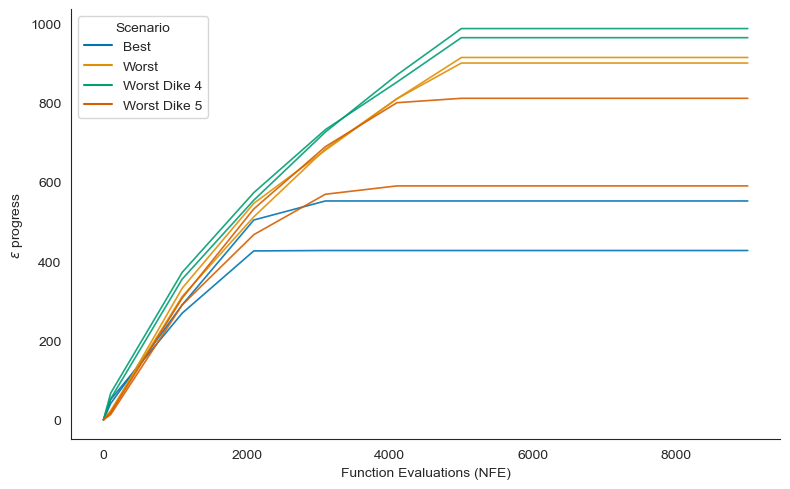

In [8]:
# === Plot epsilon progress ===
def plot_epsilon_progress(convergences, labels):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.lines as mlines

    sns.set_style("white")
    plt.figure(figsize=(8, 5))

    colors = sns.color_palette("colorblind", len(labels))
    legend_items = []

    for convergence, label, color in zip(convergences, labels, colors):
        legend_items.append((mlines.Line2D([], [], color=color), label))
        for _, group in convergence.groupby("Seed"):
            plt.plot(group.nfe, group.epsilon_progress, lw=1.2, alpha=0.9, color=color)

    plt.ylabel(r'$\epsilon$ progress')
    plt.xlabel("Function Evaluations (NFE)")
    plt.legend(*zip(*legend_items), title="Scenario")
    sns.despine()
    plt.tight_layout()
    plt.show()

plot_epsilon_progress(convergences, labels)


* Hypervolume Plot

In [18]:
# === Adjust model names for compatibility ===
def change_name_model(problem_id):
    model, planning_step = get_model_for_problem_formulation(problem_id)
    for u in model.levers:
        u.name = 'z_' + '_'.join(u.name.split(" ")).replace('.', 'z')
    for u in model.outcomes:
        u.name = 'z_' + '_'.join(u.name.split(" ")).replace('.', 'z')
    for u in model.uncertainties:
        u.name = 'z_' + '_'.join(u.name.split(" ")).replace('.', 'z')
    return model

NOT WORKING!! takes forever to run

In [ ]:
# === Problem Formulation and Model Setup ===
problem_formulation_id = 7
model = change_name_model(problem_formulation_id)
problem = to_problem(model, searchover="levers")

folder = 'mordm_Yao'
n_seed = 2
all_archives = []

# === Load and Rename All Archives ===
for label in scenarios.keys():
    for seed in range(n_seed):
        archive_file = os.path.join(folder, f'results_optimize_{label}_{seed}.tar.gz')
        archives = ArchiveLogger.load_archives(archive_file)

        for _, archive_df in archives.items():
            renamed_df = archive_df.rename(columns={x: 'z_' + "_".join(x.split(" ")) for x in archive_df.columns})
            renamed_df = renamed_df.rename(columns={x: x.replace('.', 'z') for x in renamed_df.columns})
            renamed_df["scenario"] = label
            renamed_df["seed"] = seed
            all_archives.append(renamed_df)

# === Determine Buffered Outcome Box ===
combined_df = pd.concat(all_archives, ignore_index=True)
objectives = [o.name for o in model.outcomes]
buffer = 0.1
mins = combined_df[objectives].min() * (1 - buffer)
maxs = combined_df[objectives].max() * (1 + buffer)
min_box = mins.tolist()
max_box = maxs.tolist()

# === Compute Hypervolume for Each Archive ===
hv = Hypervolume(minimum=min_box, maximum=max_box)
convergence_all = []

i = 0
for label in scenarios.keys():
    for seed in range(n_seed):
        archive_df = all_archives[i]
        i += 1

        expected_columns = [l.name for l in problem.parameters] + [o.name for o in model.outcomes]
        archive_df = archive_df[expected_columns]

        population = rebuild_platypus_population(archive_df, problem)

        metrics = pd.DataFrame([{
            "nfe": len(population),
            "hypervolume": hv.calculate(population),
            "scenario": label,
            "seed": seed
        }])
        convergence_all.append(metrics)

# === Combine and Export Results ===
convergence_df = pd.concat(convergence_all, ignore_index=True)



C:\Users\yaowa\AppData\Local\Temp\ipykernel_23268\1668660544.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_archives, ignore_index=True)


In [ ]:
# === Optional: Plotting ===
fig, ax = plt.subplots(figsize=(8, 5))
colors = sns.color_palette("colorblind", len(scenarios))
legend_items = []

for (scenario_name, scores), color in zip(convergence_df.groupby("scenario"), colors):
    legend_items.append((plt.Line2D([], [], color=color), scenario_name))
    for _, score in scores.groupby("seed"):
        ax.plot(score.nfe, score.hypervolume, lw=1.5, color=color)

ax.set_ylabel("Hypervolume")
ax.set_xlabel("Function Evaluations (NFE)")
fig.legend(*zip(*legend_items), title="Scenario", bbox_to_anchor=(1, 0.9))

sns.despine()
plt.tight_layout()
plt.show()

### Step 4: Parellel coordinate plot
After obtaining the optimization solutions, we apply post-processing filters to reflect stakeholder consensus on outcomes, levers, and constraints. To reduce computational time, constraints are not embedded in the optimization formulation but are enforced afterward. The decision space is limited to first-stage interventions, meaning only stage 0 levers—such as dike heightenings and Room for the River implementations—are retained to represent near-term planning priorities agreed upon during stakeholder debate. For Dike Ring A.4 (Gorssel), we further restrict the dike heightening lever to a maximum of 5 decimeters in accordance with local stakeholder commitments.


In [ ]:
# === Parameters ===
folder = "mordm_Yao"
n_seed = 2  # adjust to your actual number of seeds

stage1_levers = [
    "0_RfR 1", "1_RfR 1", "2_RfR 1", "3_RfR 1", "4_RfR 1",
    "A.1_DikeIncrease 1", "A.2_DikeIncrease 1", "A.3_DikeIncrease 1",
    "A.4_DikeIncrease 1", "A.5_DikeIncrease 1"
]

In [ ]:
# === Load and Save Results to CSV ===
for label in scenarios.keys():
    for seed in range(n_seed):
        file_path = os.path.join(folder, f"results_optimize_{scenario}_{seed}.tar.gz")
        archive = ArchiveLogger.load_archives(file_path)
        for key, df in archive.items():
            print(key)
            print(df.head())

In [ ]:
# === Load and Save Results to CSV ===
for label in scenarios.keys():
    for seed in range(n_seed):
        file_path = os.path.join(folder, f"results_optimize_{scenario}_{seed}.tar.gz")
        archive = ArchiveLogger.load_archives(file_path)
        for key, df in archive.items():
            print(key)
            print(df.head())

            # filter rows: all stage 1 levers == 0
            for lever in stage1_levers:
                if lever in df.columns:
                    df = df[df[lever] == 0]

            # filter: A.4_DikeIncrease 0 <= 5
            if "A.4_DikeIncrease 0" in df.columns:
                 df = df[df["A.4_DikeIncrease 0"] <= 5]

            # Save each DataFrame to a CSV file
            csv_filename = f"results_{scenario}_{seed}_{key}.csv"
            csv_path = os.path.join(folder, csv_filename)
            df.to_csv(csv_path, index=False)

In [ ]:
# === Loop through scenarios and plot parallel coordinates ===
for label in scenarios.keys():
    print(f"Plotting for scenario: {label}")
    
    # Collect outcomes for all seeds
    all_outcomes = []

    for seed in range(n_seed):
        archive_file = os.path.join(folder, f"results_optimize_{label}_{seed}.tar.gz")
        experiments, outcomes = load_results(archive_file)

        df = pd.DataFrame({k: v for k, v in outcomes.items()})
        all_outcomes.append(df)

    # Combine across seeds
    all_data = pd.concat(all_outcomes, ignore_index=True)

    # Identify lines with extreme values (min or max) on any axis
    indices = pd.concat([all_data.idxmax(), all_data.idxmin()]).unique()

    # === Plot ===
    limits = parcoords.get_limits(all_data)
    axes = parcoords.ParallelAxes(limits)

    axes.plot(all_data, color='lightgrey', lw=0.5, alpha=0.5)
    axes.plot(all_data.iloc[indices, :], color=sns.color_palette()[0], lw=1.2)

    fig = plt.gcf()
    fig.set_size_inches((10, 4))
    plt.tight_layout()
    plt.show()


In [26]:
# rename columns and select levers
stage1_levers = [
    "0_RfR 1", "1_RfR 1", "2_RfR 1", "3_RfR 1", "4_RfR 1",
    "A.1_DikeIncrease 1", "A.2_DikeIncrease 1", "A.3_DikeIncrease 1",
    "A.4_DikeIncrease 1", "A.5_DikeIncrease 1"
]

for label in scenarios.keys():
    filepath = os.path.join('mordm_Yao', f'reference_set_scenario_{label}.csv')
    
    # read, rename columns
    df = pd.read_csv(filepath)
    df.columns = df.columns.str.replace('z_', '', regex=True)
    df.columns = df.columns.str.replace('Az', 'A.', regex=True)
    df.columns = df.columns.str.replace('_', ' ', regex=True)
    df.columns = df.columns.str.replace('0 RfR', '0_RfR', regex=True)
    df.columns = df.columns.str.replace('A.1 ', 'A.1_', regex=True)
    df.columns = df.columns.str.replace('A.2 ', 'A.2_', regex=True)
    df.columns = df.columns.str.replace('A.3 ', 'A.3_', regex=True) 
    df.columns = df.columns.str.replace('A.4 ', 'A.4_', regex=True)
    df.columns = df.columns.str.replace('A.5 ', 'A.5_', regex=True)
    df.columns = df.columns.str.replace(' EWS ', 'EWS_', regex=True)


    # filter rows: all stage 1 levers == 0
    for col in stage1_levers:
        if col in df.columns:
            df = df[df[col] == 0]

    # filter: A.4_DikeIncrease 0 <= 5
    if "A.4_DikeIncrease 0" in df.columns:
        df = df[df["A.4_DikeIncrease 0"] <= 5]

    # save revised file
    revised_path = os.path.join(folder, f'renamed_reference_set_{label}.csv')
    df.to_csv(revised_path, index=False)
    
    print(f"Filtered and saved: {revised_path}")


Filtered and saved: mordm_Yao\renamed_reference_set_Best.csv
Filtered and saved: mordm_Yao\renamed_reference_set_Worst.csv
Filtered and saved: mordm_Yao\renamed_reference_set_Worst Dike 4.csv


FileNotFoundError: [Errno 2] No such file or directory: 'mordm_Yao\\reference_set_scenario_Worst Dike 5.csv'

We use the parcoords module to create parallel coordinate plots that visualize trade-offs across multiple outcomes. First, we define the axis limits based on the full dataset, and then plot all normalized solution sets with light grey lines to reveal the overall structure. Key solutions—such as those with extreme values (e.g., maximum or minimum deaths or costs)—can be overlaid in a distinct color for emphasis. Axes are inverted as needed to align all outcomes in a consistent “better-to-worse” visual direction, improving interpretability of the Pareto front structure under each scenario.

In [ ]:
list(scenarios.keys())

C:\Users\yaowa\AppData\Local\Temp\ipykernel_23240\484808034.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


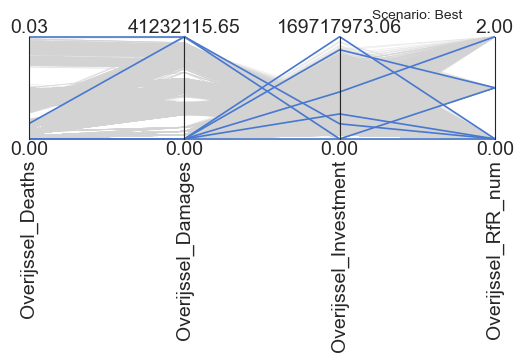

C:\Users\yaowa\AppData\Local\Temp\ipykernel_23240\484808034.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


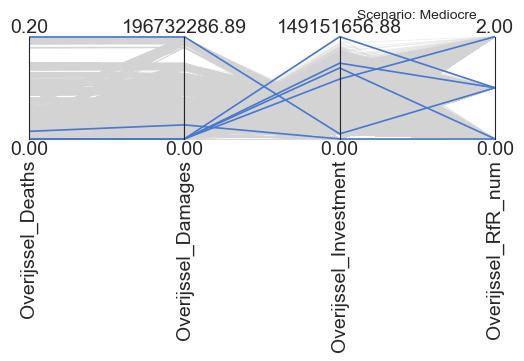

C:\Users\yaowa\AppData\Local\Temp\ipykernel_23240\484808034.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


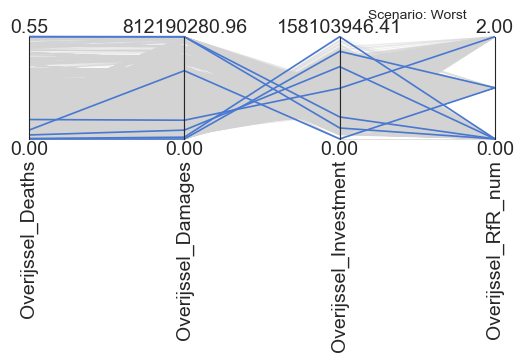

C:\Users\yaowa\AppData\Local\Temp\ipykernel_23240\484808034.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


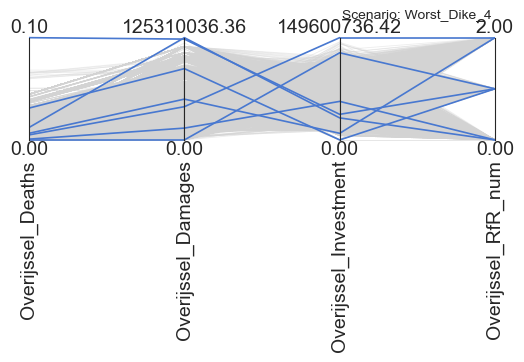

C:\Users\yaowa\AppData\Local\Temp\ipykernel_23240\484808034.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


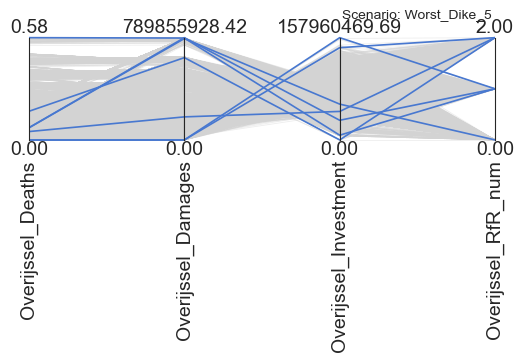

In [ ]:
# Loop over each scenario result
for df, label in zip(processed_results, scenario_labels):
    subset = df[outcomes_of_interest]
    
    # Get the indices of min and max values
    indices = pd.concat([subset.idxmax(), subset.idxmin()]).unique()

    # Define limits for the axes
    limits = parcoords.get_limits(subset)
    axes = parcoords.ParallelAxes(limits)
    
    # Grey for background
    axes.plot(subset, color='lightgrey', alpha=0.4, lw=0.6)

    # Highlight min/max in color
    axes.plot(subset.loc[indices], color=sns.color_palette("muted")[0], lw=1.2)

    # Title and layout
    plt.title(f"Scenario: {label}", fontsize=10)
    plt.gcf().set_size_inches((5, 2))  # Control figure size tightly
    plt.tight_layout()
    plt.show()
 